# Project 7 / Airport Delays + Cluster Analysis

### Description

You've been hired by the FAA as a consultant to analyze the operations of major airports around the country. The FAA wants to cut down on delays nationwide, and the most important part of this task is understanding the characteristics and groupings of airports based on a dataset of departure and operational delays.

A certain degree of delay is expected in airport operations, however the FAA is noticing significant delays with certain airports
When a flight takes off, it's departure delay is recorded in minutes, as well as operational data relating to this delay
At the end of the year, this data is averaged out for each airport. Your datasets have these averaged for a 10 year range between 2004 and 2014
Over this 10 year range, some delay times have not improved or have worsened.
Point: Your task is to understand the distribution, characteristics, and components of individual airports operations that are leading to these delays.

### Problem Statement

In this project, we're going to be using three different datasets related to airport operations. These include a dataset detailing the arrival and departure delays/diversions by airport, a dataset that provides metrics related to arrivals and departures for each airport, and a dataset that details names and characteristics for each airport code.

You will help the FAA:

Organize and store their data so that they can easily understand it after your consulting work is done
Mine and refine the data to uncover its basic attributes and characteristics
Use your skills with PCA to uncover the core components of operations related to delays.
When you've finished your analysis, the FAA would like a report detailing your findings, with recommendations as to which airports and operational characteristics they should target to decrease delays.

Here are some questions to keep in mind:

What operational factors are most directly correlated to delays?
Take a look at airports groupings - are there any relationships by region? Size?

### Step 1: Load Packages and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from lib.get_pca import feature_importance
from lib.cluster import kmeans, find_best_cluster

In [2]:
cancel_loc = "data/airport_cancellations.csv"
ops_loc = "data/Airport_operations.csv"
airports_loc = "data/airports.csv"

cancel = pd.read_csv(cancel_loc)
ops = pd.read_csv(ops_loc)
airports = pd.read_csv(airports_loc)

#### Airport Cancellations

In [3]:
cancel.head()

,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0
2,ABQ,2006.0,392.0,329.0,71.0,124.0
3,ABQ,2007.0,366.0,304.0,107.0,45.0
4,ABQ,2008.0,333.0,300.0,79.0,42.0


In [4]:
cancel.shape

(805, 6)

#### Airport Operations

In [5]:
ops.head()

,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2006,49682,51199,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2007,53255,53611,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2008,49589,49512,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


In [6]:
ops.rename(columns={'airport':'Airport',
                    'departures for metric computation': 'departures_for_computation',
                    'arrivals for metric computation' : 'arrivals_for_computation',
                    'percent on-time gate departures' : 'percent_on_time_gate_departures',
                    'percent on-time airport departures' : 'percent_on_time_airport_departures',
                    'percent on-time gate arrivals' : 'percent_on_time_gate_arrivals',
                    'average_gate_departure_delay' : 'avg_gate_departure_delay',
                    'average taxi out delay': 'avg_taxi_out_delay',
                    'average airport departure delay': 'avg_departure_delay',
                    'average airborne delay': 'avg_airborne_delay',
                    'average taxi in delay': 'avg_taxi_in_delay',
                    'average block delay': 'avg_block_delay',
                    'average gate arrival delay': 'avg_gate_arrival_delay'}, inplace=True)

In [7]:
ops.columns

Index([u'Airport', u'year', u'departures_for_computation',
       u'arrivals_for_computation', u'percent_on_time_gate_departures',
       u'percent_on_time_airport_departures', u'percent_on_time_gate_arrivals',
       u'avg_gate_departure_delay', u'average_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_departure_delay', u'avg_airborne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_gate_arrival_delay'],
      dtype='object')

In [8]:
ops.shape

(841, 15)

#### Join Airport Operations and Airport Cancellations

In [9]:
full_ops = pd.merge(ops, cancel, on='Airport', how='right')

#### Airport Delays

In [10]:
mask = ['avg_gate_departure_delay',
        'avg_taxi_out_delay',
        'avg_departure_delay',
        'avg_airborne_delay',
        'avg_taxi_in_delay', 
        'avg_block_delay',
        'avg_gate_arrival_delay']

In [11]:
delays = ops[mask]
delays.head()

,avg_gate_departure_delay,avg_taxi_out_delay,avg_departure_delay,avg_airborne_delay,avg_taxi_in_delay,avg_block_delay,avg_gate_arrival_delay
0,10.38,2.43,12.10,2.46,0.83,2.55,10.87
1,9.60,2.29,11.20,2.26,0.89,2.34,10.24
2,10.84,2.16,12.33,2.12,0.84,2.66,11.82
3,11.29,2.40,12.95,2.19,1.29,3.06,12.71
4,10.79,2.41,12.32,1.82,1.03,2.79,11.48


In [12]:
delays.shape

(841, 7)

#### Airports

In [13]:
airports.head()

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No
2,2886.0,PSE,MERCEDITA,Aeropuerto Mercedita,Airport,ASO,#NAME?,PONCE,PR,Public Use,18.008306,-66.563028,Yes
3,2879.0,VQS,ANTONIO RIVERA RODRIGUEZ,Aeropuerto Antonio Rivera Rodr�guez,Airport,ASO,#NAME?,ISLA DE VIEQUES,PR,Public Use,18.134811,-65.493617,Yes
4,2883.0,X63,HUMACAO,Aeropuerto Regional De Humacao,Airport,ASO,#NAME?,HUMACAO,PR,Public Use,18.138017,-65.800718,Yes


In [14]:
airports = airports.dropna()

In [15]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 5163
Data columns (total 13 columns):
Key                        3498 non-null float64
LocID                      3498 non-null object
AP_NAME                    3498 non-null object
ALIAS                      3498 non-null object
Facility Type              3498 non-null object
FAA REGION                 3498 non-null object
COUNTY                     3498 non-null object
CITY                       3498 non-null object
STATE                      3498 non-null object
AP Type                    3498 non-null object
Latitude                   3498 non-null float64
Longitude                  3498 non-null float64
Boundary Data Available    3498 non-null object
dtypes: float64(3), object(10)
memory usage: 382.6+ KB


In [16]:
airports.rename(columns={'Key':'key',
                         'LocID': 'Airport',
                         'AP_NAME': 'airport name',
                         'Facility Type': 'facility type',
                         'FAA REGION': 'FAA region',
                         'COUNTY': 'county',
                         'CITY': 'city',
                         'STATE': 'state',
                         'AP Type': 'airport type',
                         'Latitude': 'latitude',
                         'Longitude': 'longiutde'}, inplace=True)

---

### Step 2: Exploratory Data Analysis

#### Airport Cancellations

In [17]:
cancel.columns

Index([u'Airport', u'Year', u'Departure Cancellations',
       u'Arrival Cancellations', u'Departure Diversions',
       u'Arrival Diversions'],
      dtype='object')

In [18]:
# Create percentages columns
cancel['total cancellations'] = cancel['Departure Cancellations'] + cancel['Arrival Cancellations']
cancel['total diversions'] = cancel['Departure Diversions'] + cancel['Arrival Diversions']
cancel['percentage_of_departure_cancellations'] = 1.0 * cancel['Departure Cancellations'] / cancel['total cancellations']
cancel['percentage_of_arrival_cancellations'] = 1.0 * cancel['Arrival Cancellations'] / cancel['total cancellations']
cancel['percentage_of_departure_diversions'] = 1.0 * cancel['Departure Diversions'] / cancel['total diversions']
cancel['percentage_of_arrival_diversions'] = 1.0 * cancel['Arrival Diversions'] / cancel['total diversions']

# Keep only percentages columns
cancel = cancel.drop(['Departure Cancellations',
                      'Arrival Cancellations',
                      'Departure Cancellations',
                      'Departure Diversions',
                      'Arrival Diversions',
                      'total cancellations',
                      'total diversions'], axis=1)

In [19]:
cancel = cancel.dropna()

In [20]:
cancel.head()

,Airport,Year,percentage_of_departure_cancellations,percentage_of_arrival_cancellations,percentage_of_departure_diversions,percentage_of_arrival_diversions
0,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162
1,ABQ,2005.0,0.537713,0.462287,0.648936,0.351064
2,ABQ,2006.0,0.543689,0.456311,0.364103,0.635897
3,ABQ,2007.0,0.546269,0.453731,0.703947,0.296053
4,ABQ,2008.0,0.526066,0.473934,0.652893,0.347107


In [21]:
cleaned_df = pd.merge(cancel, ops, how='inner', on='Airport')

In [22]:
cleaned_df.columns

Index([u'Airport', u'Year', u'percentage_of_departure_cancellations',
       u'percentage_of_arrival_cancellations',
       u'percentage_of_departure_diversions',
       u'percentage_of_arrival_diversions', u'year',
       u'departures_for_computation', u'arrivals_for_computation',
       u'percent_on_time_gate_departures',
       u'percent_on_time_airport_departures', u'percent_on_time_gate_arrivals',
       u'avg_gate_departure_delay', u'average_taxi_out_time',
       u'avg_taxi_out_delay', u'avg_departure_delay', u'avg_airborne_delay',
       u'avg_taxi_in_delay', u'avg_block_delay', u'avg_gate_arrival_delay'],
      dtype='object')

In [23]:
cleaned_df.drop(['departures_for_computation',
                 'arrivals_for_computation', 
                 'year'], axis=1, inplace=True)

In [24]:
features = [col for col in cleaned_df.columns if col not in ['Year', 'Airport']]

In [25]:
cleaned_df.head()

,Airport,Year,percentage_of_departure_cancellations,percentage_of_arrival_cancellations,percentage_of_departure_diversions,percentage_of_arrival_diversions,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,avg_gate_departure_delay,average_taxi_out_time,avg_taxi_out_delay,avg_departure_delay,avg_airborne_delay,avg_taxi_in_delay,avg_block_delay,avg_gate_arrival_delay
0,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162,0.8030,0.7809,0.7921,10.38,9.89,2.43,12.10,2.46,0.83,2.55,10.87
1,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162,0.8140,0.7922,0.8001,9.60,9.79,2.29,11.20,2.26,0.89,2.34,10.24
2,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162,0.7983,0.7756,0.7746,10.84,9.89,2.16,12.33,2.12,0.84,2.66,11.82
3,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162,0.8005,0.7704,0.7647,11.29,10.34,2.40,12.95,2.19,1.29,3.06,12.71
4,ABQ,2004.0,0.507338,0.492662,0.606838,0.393162,0.8103,0.7844,0.7875,10.79,10.41,2.41,12.32,1.82,1.03,2.79,11.48


#### Cancellations Pivot Table

In [26]:
pd.pivot_table(cancel, index='Year', columns='Airport', aggfunc='sum')

percentage_of_departure_cancellations                                \
Airport                                   ABQ       ANC       ATL       AUS   
Year                                                                          
2004.0                               0.507338  0.470647  0.482733  0.522453   
2005.0                               0.537713  0.466960  0.488646  0.514184   
2006.0                               0.543689  0.457036  0.475691  0.532044   
2007.0                               0.546269  0.459079  0.465926  0.516875   
2008.0                               0.526066  0.430177  0.465098  0.515493   
2009.0                               0.542373  0.456774  0.457900  0.533095   
2010.0                               0.556391  0.422096  0.469074  0.536953   
2011.0                               0.539906  0.418860  0.466914  0.515777   
2012.0                               0.566986  0.432000  0.448125  0.522189   
2013.0                               0.522523  0.433846  0.458058  0.550847   
2014.0                               0.534805  0.406593  0.479695  0.526659   

                                                                       ...     \
Airport       BDL       BHM       BNA       BOS       BUF       BUR    ...      
Year                                                                   ...      
2004.0   0.536524  0.547684  0.509831  0.499176  0.541623  0.502868    ...      
2005.0   0.518012  0.514742  0.523739  0.502633  0.522936  0.548077    ...      
2006.0   0.535817  0.527574  0.509304  0.504279  0.533397  0.516324    ...      
2007.0   0.524965  0.553012  0.511029  0.507063  0.525553  0.520121    ...      
2008.0   0.540516  0.530303  0.515645  0.503721  0.531304  0.513436    ...      
2009.0   0.524962  0.543668  0.536015  0.504626  0.533333  0.513716    ...      
2010.0   0.523008  0.542169  0.516317  0.502948  0.534292  0.511551    ...      
2011.0   0.525685  0.522593  0.507339  0.499173  0.516689  0.536453    ...      
2012.0   0.534420  0.506897  0.523508  0.495862  0.525478  0.516949    ...      
2013.0   0.523741  0.521851  0.528875  0.501069  0.542416  0.508280    ...      
2014.0   0.525901  0.519320  0.508842  0.498493  0.521295  0.514458    ...      

        percentage_of_arrival_diversions                                \
Airport                              SFO       SJC       SJU       SLC   
Year                                                                     
2004.0                          0.357326  0.500000  0.337349  0.254098   
2005.0                          0.334951  0.330769  0.360000  0.254425   
2006.0                          0.351499  0.522843  0.411215  0.246032   
2007.0                          0.327935  0.345455  0.375000  0.188506   
2008.0                          0.415385  0.439394  0.271028  0.293515   
2009.0                          0.391129  0.326087  0.504348  0.298273   
2010.0                          0.490934  0.373913  0.354331  0.332873   
2011.0                          0.497674  0.541985  0.352564  0.296364   
2012.0                          0.468793  0.402439  0.398058  0.165775   
2013.0                          0.524807  0.294118  0.496124  0.491554   
2014.0                          0.459559  0.326923  0.300971  0.270341   

                                                                     
Airport       SMF       SNA       STL       SWF       TPA       TUS  
Year                                                                 
2004.0   0.547619  0.507109  0.531496  0.428571  0.474403  0.305556  
2005.0   0.500000  0.557895  0.460317  0.583333  0.326984  0.419355  
2006.0   0.419847  0.553360  0.429603  0.571429  0.489637  0.422018  
2007.0   0.346405  0.491468  0.510638  0.525000  0.394137  0.252874  
2008.0   0.360000  0.522449  0.504587  0.535714  0.484043  0.213333  
2009.0   0.292683  0.425414  0.423469  0.461538  0.336634  0.424242  
2010.0   0.263566  0.477157  0.397196  0.705882  0.471380  0.454545  
2011.0   0.443609  0.445087  

#### Airport Operations

Based on the histograms, we can tell that the data has a normal distribution.

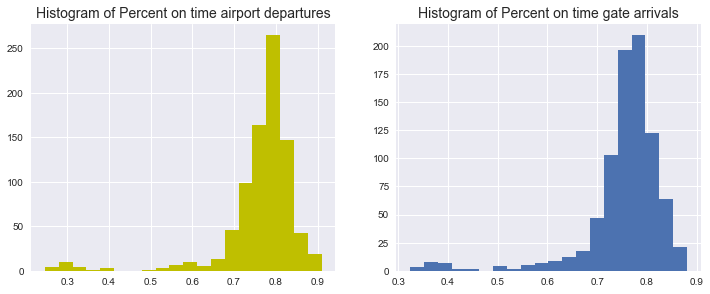

In [27]:
fig = plt.subplots(figsize=(12,10))

ax1 = plt.subplot(221)
plt.hist(ops['percent_on_time_gate_departures'], bins=20, color='y')
plt.title('Histogram of Percent on time airport departures', fontsize = 14)

ax2 = plt.subplot(222)
plt.hist(ops['percent_on_time_gate_arrivals'], bins=20)
plt.title('Histogram of Percent on time gate arrivals', fontsize = 14)

plt.show()

#### Correlations in Delays

Some features have a strong correlation, suggesting that dimensionality reduction can be possible on the features of the data set.

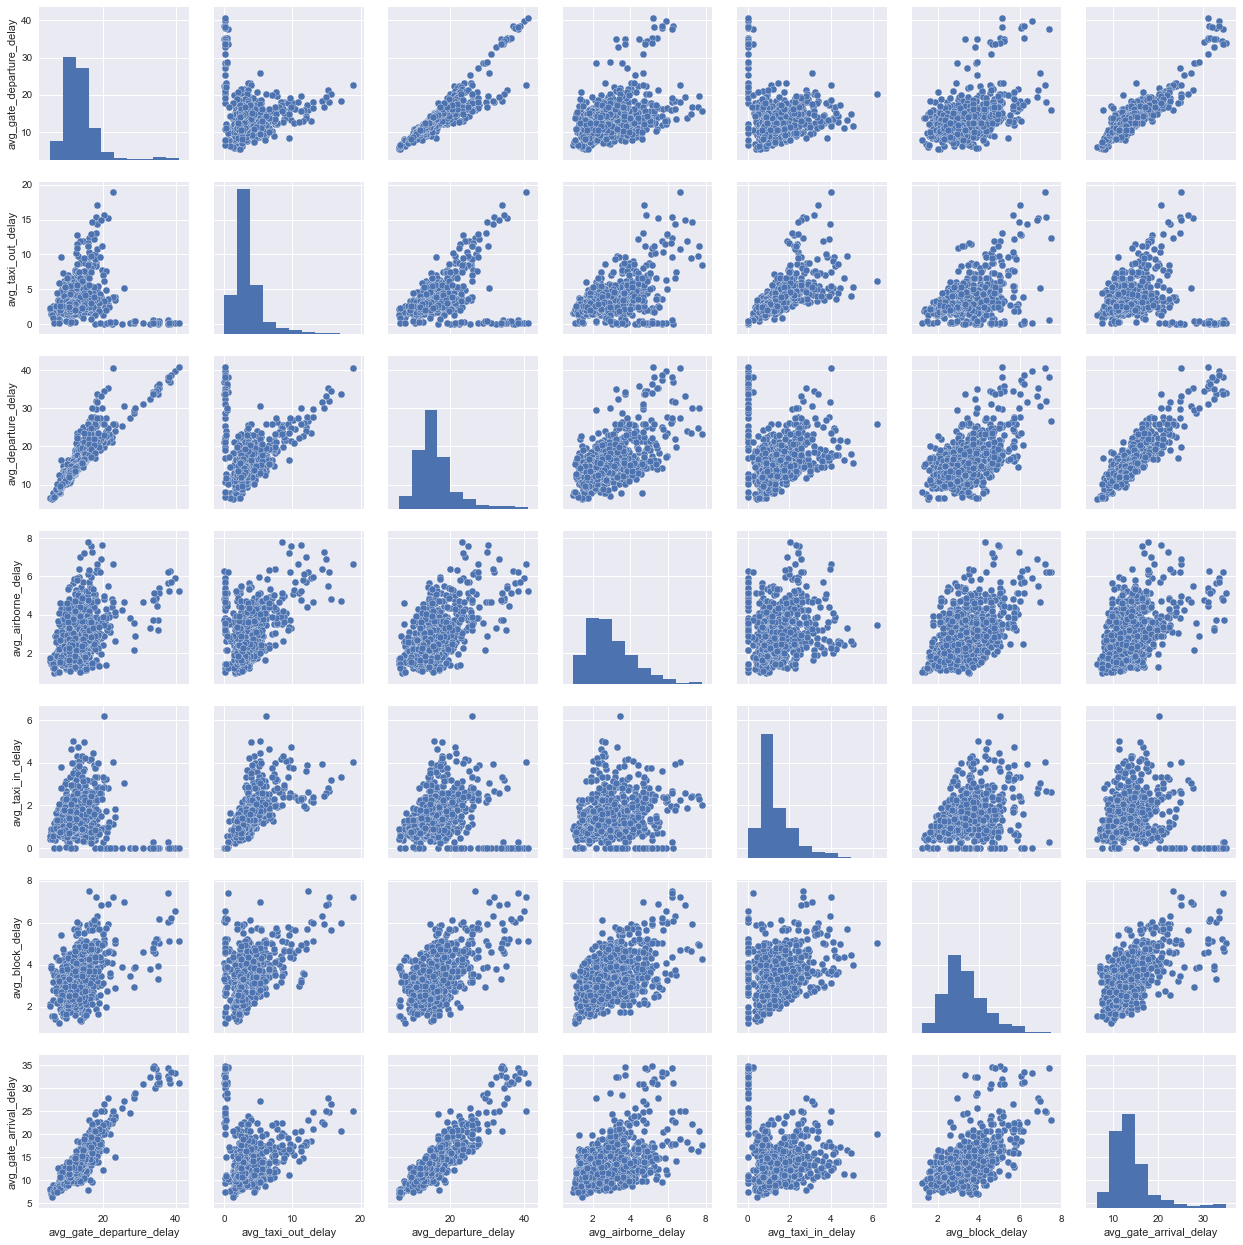

In [28]:
sns.pairplot(delays)

---

### Step 3: Principal Component Analysis

#### Principal Component Analysis on Delays

In [29]:
ss = StandardScaler()
scaled_delays = ss.fit_transform(delays)

In [30]:
pca = PCA(n_components=2)
X_r = pca.fit(scaled_delays).transform(scaled_delays)

print('explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [ 0.55125557  0.25952781]


In [31]:
pd.DataFrame(zip(delays.columns, pca.components_[0]), 
             columns=['Columns', 'Importance'])\
                .sort_values('Importance', ascending=False)

,Columns,Importance
2,avg_departure_delay,0.483154
6,avg_gate_arrival_delay,0.440044
0,avg_gate_departure_delay,0.411762
5,avg_block_delay,0.406831
3,avg_airborne_delay,0.369699
1,avg_taxi_out_delay,0.266244
4,avg_taxi_in_delay,0.174071


I'm using Principal Component Analysis on my `delays` dataframe for exploratory data analysis and found the importance of each type of delay. It shows that the most important delay is:
1. average departure delay
2. average gate arrival delay
3. average gate departure delay
4. average block delay
5. average airborne delay
6. average taxi out delay
7. average taxi in delay

#### Principal Component Analysis on Operations/Cancellations

In [32]:
X = cleaned_df.drop('Airport', axis=1)
scaled_cleaned_df = ss.fit_transform(X)

In [33]:
pca = PCA(n_components=7)
X_pca = pca.fit(scaled_cleaned_df).transform(scaled_cleaned_df)

explained_variance = pca.explained_variance_ratio_

print('explained variance ratio: %s' % str(explained_variance))

explained variance ratio: [ 0.43686506  0.18126533  0.12043329  0.07557622  0.06249104  0.04147995
  0.03604126]


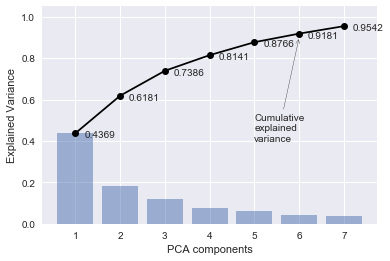

In [34]:
# Cumulative Explained Variance
x = np.arange(1,8)
plt.plot(x, np.cumsum(explained_variance), '-o', color='black')
plt.bar(x, explained_variance, align='center', alpha=0.5)

plt.ylim(0, 1.05)
plt.annotate('Cumulative\nexplained\nvariance',
             xy=(6, .9), arrowprops=dict(arrowstyle='->'), xytext=(5, .4))

for i,j in zip(x, np.cumsum(explained_variance)):
    plt.annotate(str(j.round(4)),xy=(i+.2,j-.02))

plt.xticks(range(1,8))
plt.xlabel('PCA components')
plt.ylabel('Explained Variance')
plt.show()

#### At 6 principal components, we captured more than 90% of the explained variance.

In [35]:
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.metrics import silhouette_score

k_vals = range(2,6)

from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression()

for k in k_vals:
    my_kmean = KMeans(n_clusters=k)
    my_kmean.fit(X_pca)
    labels = my_kmean.labels_
    print k, cross_val_score(log_clf, X_pca, labels, cv=10).mean(), silhouette_score(X_pca, labels)

2 0.997130130623 0.32376184338
3 0.97348305234 0.197535433276
4 0.934814388822 0.201324337381
5 0.878128580998 0.168494737858


At k=2, the Cross Validation score and the Silhouette Score look pretty good, so we will cluster on 2 groups.

---

### Step 4: KMeans Clustering

#### Principal Component Analysis

In [36]:
# This KMeans clustering module returns labels, centroids, and inertia
kmeans = kmeans(X_pca, 2)

In [37]:
kmeans['silhouette_score']

0.32366144976642147

In [38]:
pca_labels = kmeans['labels']
cleaned_df['labels'] = kmeans['labels']

#### Cluster Analysis

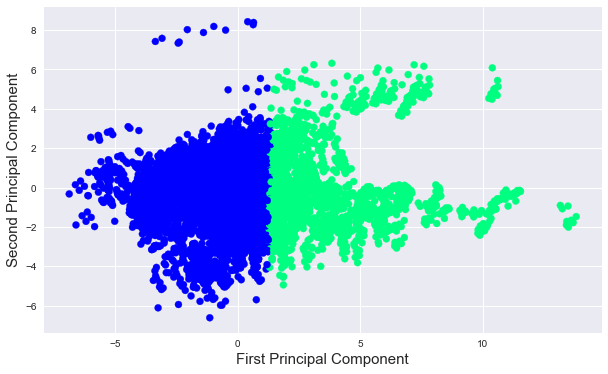

In [39]:
plt.figure(figsize=(10,6))
plt.scatter(x=X_pca[:,0], y=X_pca[:,1], c=pd.DataFrame(pca_labels).values, alpha=1)
plt.set_cmap('winter')
plt.xlabel('First Principal Component', fontsize=15)
plt.ylabel('Second Principal Component', fontsize=15)
plt.show()

#### tSNE

In [40]:
from sklearn.manifold import TSNE
my_tsne = TSNE(n_components=2)

In [41]:
X_tsne = my_tsne.fit_transform(scaled_cleaned_df)

In [42]:
my_kmean = KMeans(n_clusters=2)
my_kmean.fit(X_tsne)
tsne_labels = my_kmean.labels_

#### Cluster Analysis

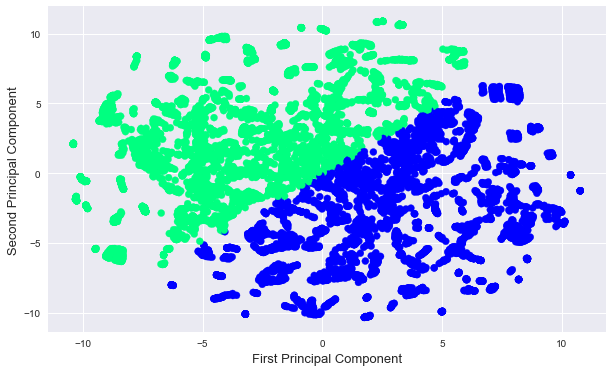

In [43]:
plt.figure(figsize=(10,6))
plt.scatter(x=X_tsne[:,0], y=X_tsne[:,1], c=pd.DataFrame(tsne_labels).values, alpha=1)
plt.xlabel('First Principal Component', fontsize=13)
plt.ylabel('Second Principal Component', fontsize=13)
plt.show()

---

### Step 5: Analysis and Results

KMeans Clustering with 2 groups indicates that it is possible to classify the airports using either PCA or tSNE.

In [44]:
group0_df = cleaned_df[labels==0]
group1_df = cleaned_df[labels==1]

In [45]:
group0_df.describe() - group1_df.describe()

,Year,percentage_of_departure_cancellations,percentage_of_arrival_cancellations,percentage_of_departure_diversions,percentage_of_arrival_diversions,percent_on_time_gate_departures,percent_on_time_airport_departures,percent_on_time_gate_arrivals,avg_gate_departure_delay,average_taxi_out_time,avg_taxi_out_delay,avg_departure_delay,avg_airborne_delay,avg_taxi_in_delay,avg_block_delay,avg_gate_arrival_delay,labels
count,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000,-813.000000
mean,-0.086132,-0.013455,0.013455,-0.020497,0.020497,-0.119972,-0.142217,-0.100093,6.917921,2.099168,1.076473,8.104547,0.924708,0.418198,1.167257,6.211381,0.766142
std,-0.004560,0.002710,0.002710,0.017713,0.017713,0.017263,0.009617,0.020854,0.474524,0.829983,0.458383,0.293917,0.243015,0.349107,0.344691,1.220832,0.423450
min,0.000000,-0.043407,0.000000,0.000000,0.172840,-0.141800,-0.143900,-0.181200,6.660000,0.000000,0.550000,8.210000,0.310000,0.230000,0.410000,3.690000,0.000000
25%,0.000000,-0.018329,0.007711,-0.038970,0.004786,-0.115700,-0.136200,-0.104600,6.560000,1.680000,0.570000,7.780000,0.750000,0.120000,0.995000,5.160000,1.000000
50%,0.000000,-0.013632,0.013632,-0.004830,0.004830,-0.105500,-0.124400,-0.083600,6.230000,1.630000,1.110000,7.430000,0.950000,0.350000,1.215000,5.880000,1.000000
75%,0.000000,-0.007711,0.018329,-0.004786,0.038970,-0.102725,-0.131900,-0.082325,7.040000,3.090000,1.290000,8.170000,1.080000,0.600000,1.540000,6.937500,1.000000
max,0.000000,0.000000,0.043407,-0.172840,0.000000,-0.120000,-0.150700,-0.062000,8.580000,1.970000,2.190000,9.220000,0.070000,1.960000,1.650000,8.640000,1.000000


#### Differences between Airport Groups

While both airport groups have similar operational natures (e.g. percent on time flights, etc.), both are different in the absolute values of flight cancellations and delays. This may suggest that the KMeans Clustering grouped the airports into small and big airports.

#### Principal Component Analysis

In [46]:
X_g0 = StandardScaler().fit_transform(group0_df[features])
X_g1 = StandardScaler().fit_transform(group1_df[features])

In [47]:
my_pca = PCA(n_components=2)

pca_loadings_g0 = pd.DataFrame(my_pca.fit(X_g0).components_.T, index=features, columns=['PC1_good_aprt', 'PC2'])

good_arpt = pca_loadings_g0.PC1_good_aprt.abs().sort_values(ascending=True)

In [48]:
pca_loadings_g1 = pd.DataFrame(my_pca.fit(X_g1).components_.T, index=features, 
                               columns=['PC1_bad_aprt', 'PC2'])
bad_arpt = pca_loadings_g1.PC1_bad_aprt.abs().sort_values(ascending=True)

In [49]:
pca_loadings_g1

,PC1_bad_aprt,PC2
percentage_of_departure_cancellations,0.026988,0.249941
percentage_of_arrival_cancellations,-0.026988,-0.249941
percentage_of_departure_diversions,0.156288,0.164009
percentage_of_arrival_diversions,-0.156288,-0.164009
percent_on_time_gate_departures,0.389705,-0.170389
percent_on_time_airport_departures,0.403323,-0.023257
percent_on_time_gate_arrivals,0.339259,-0.186433
avg_gate_departure_delay,-0.392987,0.117339
average_taxi_out_time,-0.105204,-0.474770
avg_taxi_out_delay,-0.209644,-0.368396


In [50]:
def remove_underscore(aa):
    return aa.replace('_',' ')

In [51]:
compare = pd.merge(pd.DataFrame(good_arpt).reset_index(), 
          pd.DataFrame(bad_arpt).reset_index())

In [52]:
compare

,index,PC1_good_aprt,PC1_bad_aprt
0,average_taxi_out_time,0.020184,0.105204
1,avg_airborne_delay,0.054607,0.089022
2,avg_taxi_in_delay,0.060321,0.085188
3,avg_taxi_out_delay,0.062561,0.209644
4,percentage_of_departure_diversions,0.190170,0.156288
5,percentage_of_arrival_diversions,0.190170,0.156288
6,avg_block_delay,0.195796,0.094806
7,percentage_of_departure_cancellations,0.224549,0.026988
8,percentage_of_arrival_cancellations,0.224549,0.026988
9,avg_departure_delay,0.319609,0.414102


#### PCA Loadings

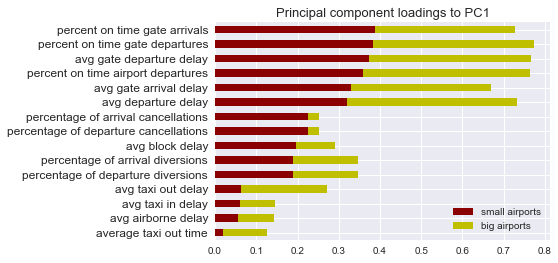

In [53]:
ax = compare.plot(kind = 'barh', color =['darkred','y'], stacked=True)
ax.set_yticklabels( compare['index'].apply(remove_underscore), fontsize = 12, rotation=0)
plt.legend(['small airports','big airports'], loc='best')  

plt.title('Principal component loadings to PC1', fontsize=13)
plt.figure(figsize=(15,10))
plt.show()

#### Final Thoughts

Based on a few observations, I noted that big airports have a higher percentage of departure and arrival cancellations, average taxi out time and delay, and average gate arrival delays. Whereas small airports had higher percent on time gate departures and airport departures, etc.